# Relevance Vector Machine 

The relevance vector machine is a probabilisic linear model in which the prior weights are taken to be normally distibuted with mean zero and a diagonal matrix.

$$
\begin{align}
    p({\bf w} | {\bf t}, {\bf \alpha}, {\bf \beta}) &\propto p({\bf w}| {\bf \alpha}) p({\bf t}| y({\bf x}), \beta)\\
    &= \mathcal{N}({\bf w}|{\bf 0}, A) \prod_{n=1}^N\mathcal{N}(t_n|y(x_n), \beta^{-1})
\end{align}
$$

Where $A = \text{diag}(\alpha_1, \ldots, \alpha_M)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn, seed, uniform
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import multivariate_normal

In [2]:
from pymc3.gp.util import plot_gp_dist

In [3]:
%config InlineBackend.figure_format = "retina"
np.set_printoptions(precision=3, suppress=True)

## The Test Data

In [4]:
nobs = 50
seed(3141)
X = np.linspace(0, 1, nobs) + uniform(0, 0.01, nobs)
y = np.sin(2 * np.pi * X) + randn(nobs) * 0.3

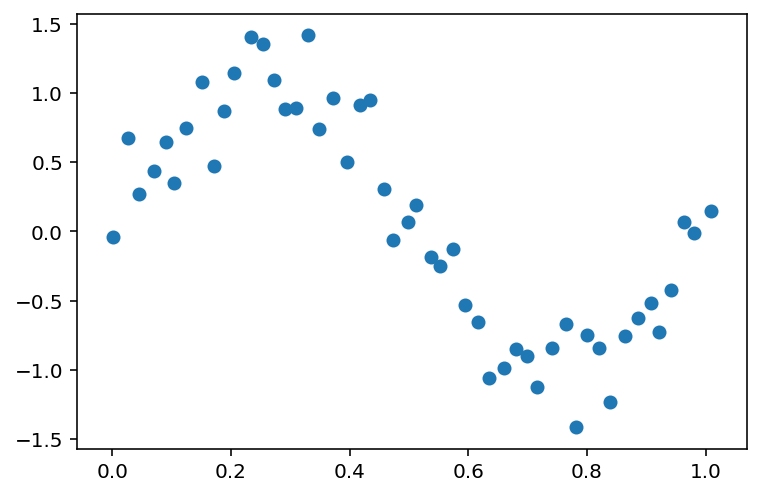

In [5]:
plt.scatter(X, y)

## Radial Basis Function Kernel

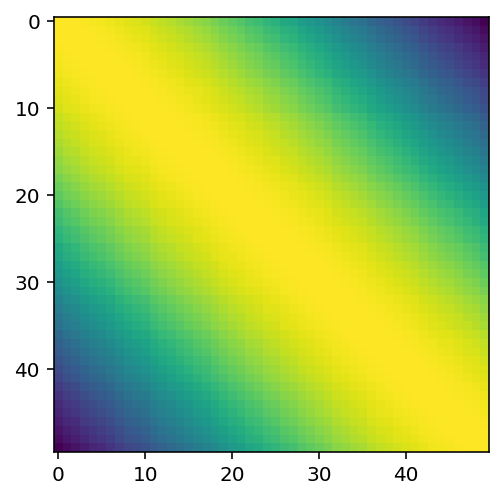

In [6]:
Phi = np.exp(-(X[np.newaxis, :] - X[:, np.newaxis]) ** 2)
plt.imshow(Phi)

In [7]:
seed(1643)
alpha = np.abs(randn(Phi.shape[1]) * 0.5)
beta, *_ = np.abs(randn(1)) * 0.5

In [8]:
A = np.identity(len(alpha)) * alpha
Sigma = np.linalg.inv(A + beta * Phi.T @ Phi)
m = beta * Sigma @ Phi.T @ y[:, np.newaxis]

mvn = multivariate_normal(mean=m.ravel(), cov=Sigma)

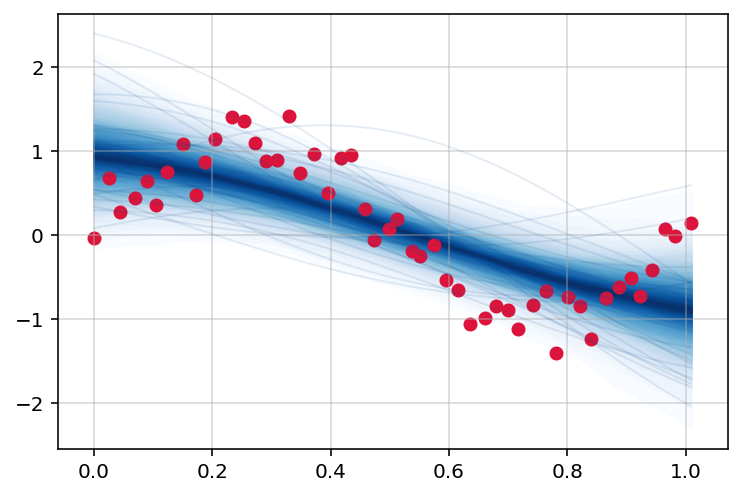

In [9]:
fig, ax = plt.subplots(1, 1)
plot_gp_dist(ax, (Phi @ mvn.rvs(500).T).T, X, palette="Blues")
ax.scatter(X, y, c="crimson")
ax.grid(alpha=0.5)

## Polynomial feature matrix

In [10]:
poly = PolynomialFeatures(degree=5, include_bias=True)
Phi = poly.fit_transform(X[:, np.newaxis])

seed(3141)
alpha = np.abs(randn(Phi.shape[1]))
beta, *_ = randn(1) * 0.5


A = np.identity(len(alpha)) * alpha
Sigma = np.linalg.inv(A + beta * Phi.T @ Phi)
m = beta * Sigma @ Phi.T @ y[:, np.newaxis]

mvn = multivariate_normal(mean=m.ravel(), cov=Sigma)

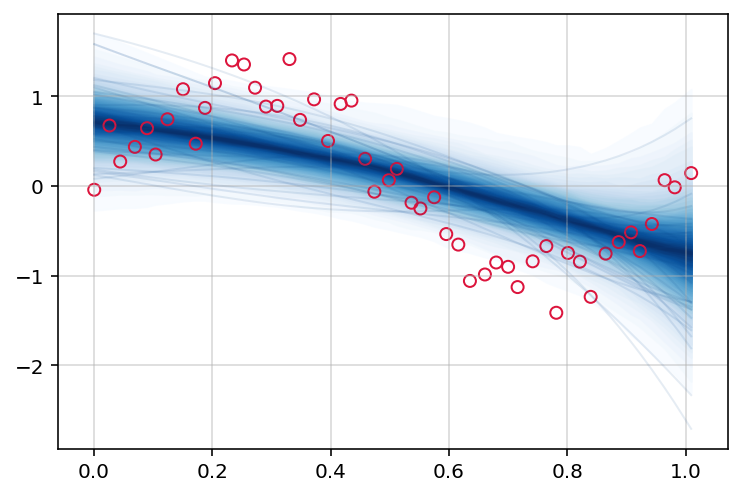

In [11]:
fig, ax = plt.subplots(1, 1)
plot_gp_dist(ax, (Phi @ mvn.rvs(500).T).T, X, palette="Blues")
ax.scatter(X, y, facecolors="none", edgecolor="crimson")
ax.grid(alpha=0.5)

### Implementing the Marginal Likelihood

As of now, the hyperparameters $\alpha$, $\beta$ where randonmly chosen, we will now make use of the log-marginal likelihood to find the hyperparameters that best represent the data

In [12]:
poly = PolynomialFeatures(degree=5, include_bias=True)
Phi = poly.fit_transform(X[:, np.newaxis])

seed(314)
alpha = np.clip(np.abs(randn(Phi.shape[1])), 0, 0.8)
beta, *_ = np.abs(randn(1) + 1)

In [13]:
N, _ = Phi.shape

alpha_hist = [alpha]
for _ in range(10):
    A = np.identity(len(alpha)) * alpha
    # Inverse using the Cholesky decomposition
    L = np.linalg.cholesky(A + beta * Phi.T @ Phi)
    Sigma = np.linalg.inv(L).T @ np.linalg.inv(L)
    m = beta * Sigma @ Phi.T @ y[:, np.newaxis]
    gamma = 1 - alpha * np.diag(Sigma)

    new_alpha = gamma / m.ravel() ** 2
    new_beta = (N - gamma.sum()) / (np.linalg.norm(y[:, np.newaxis] - Phi @ m) ** 2)
    

    alpha = new_alpha
    beta = new_beta
    
    alpha_hist.append(alpha)

In [14]:
alpha

array([2388.381,    0.012,    0.002,    0.01 ,    0.083,    0.033])

In [15]:
np.linalg.eigvals(Sigma)

array([39.68 ,  4.219,  1.142,  0.045,  0.001,  0.004])

Iterating over the reestimating equations

$$
    \alpha_i = \frac{\gamma_i}{m_i^2}\\
$$
$$
    \frac{1}{\beta} = \frac{||\bf{t} - \Phi\bf{m}||^2}{N - \sum_m \gamma_m}
$$

result to be unsteady.

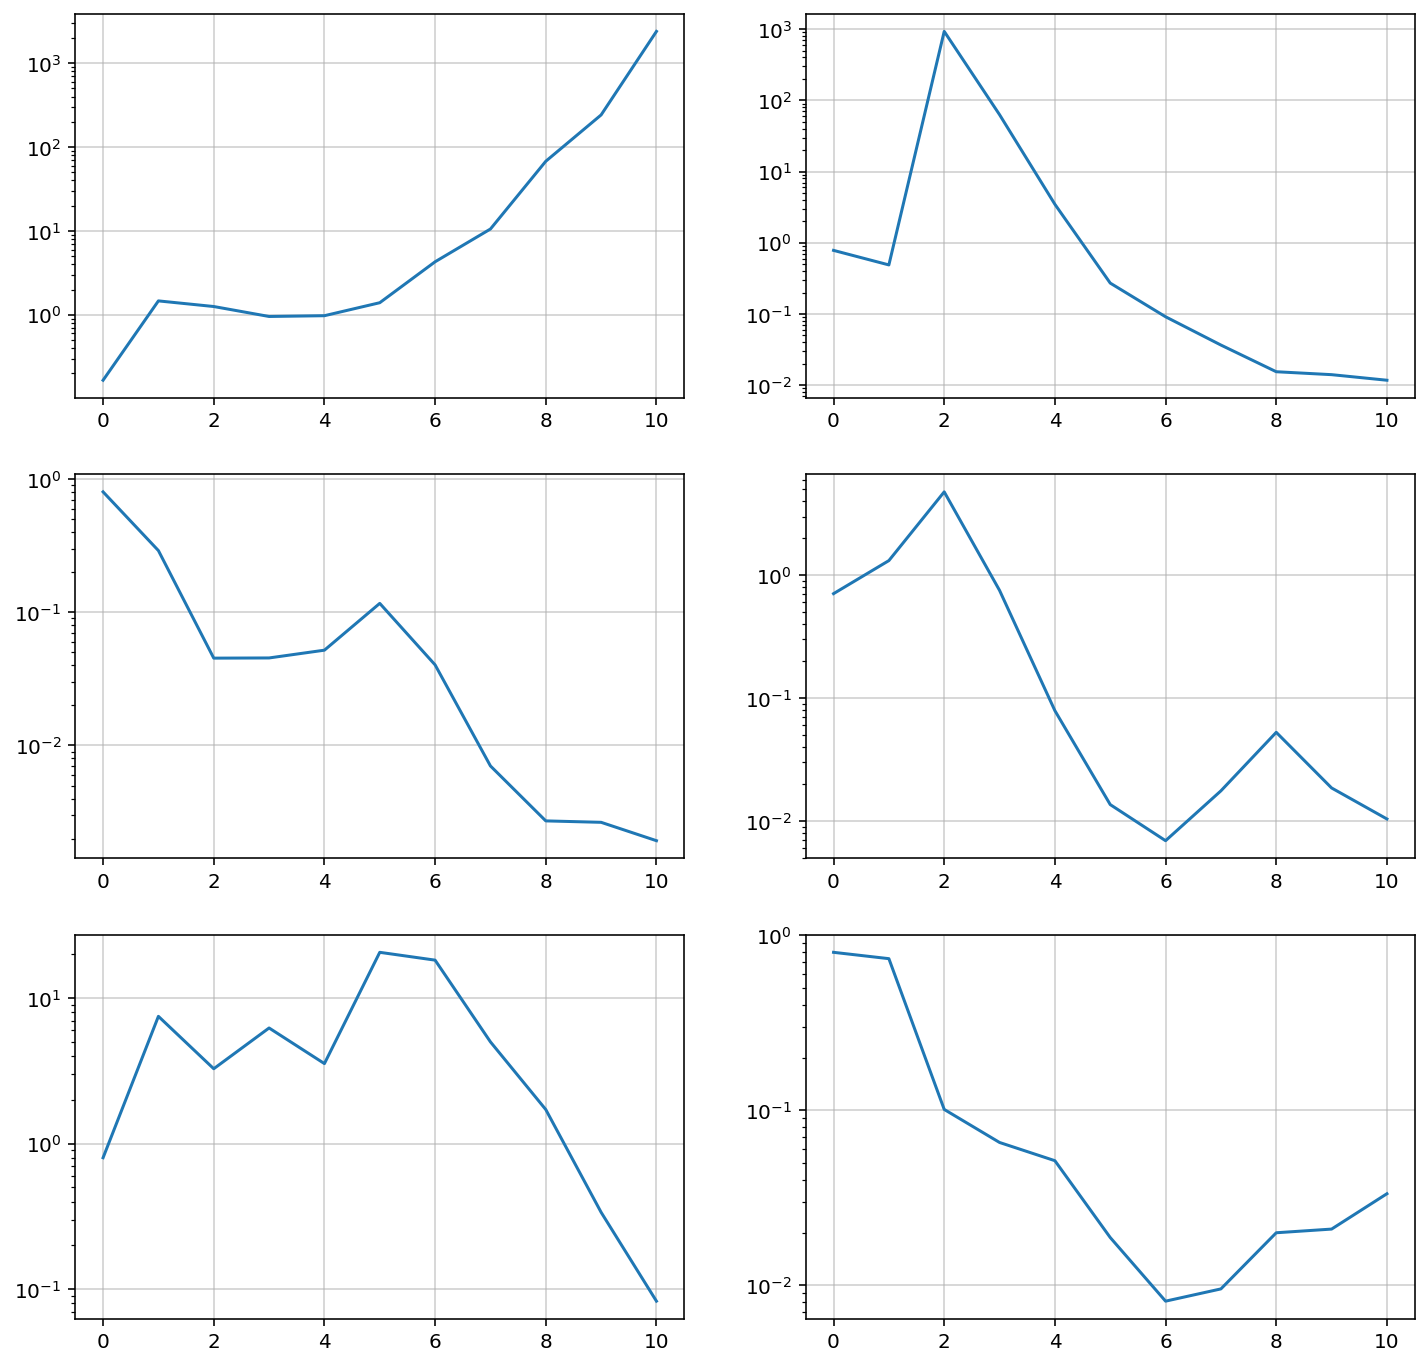

In [16]:
alpha_hist = np.r_[alpha_hist]
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
for axi, hist in zip(ax.ravel(), alpha_hist.T):
    axi.plot(hist)
    axi.set_yscale("log")
    axi.grid(alpha=0.6)

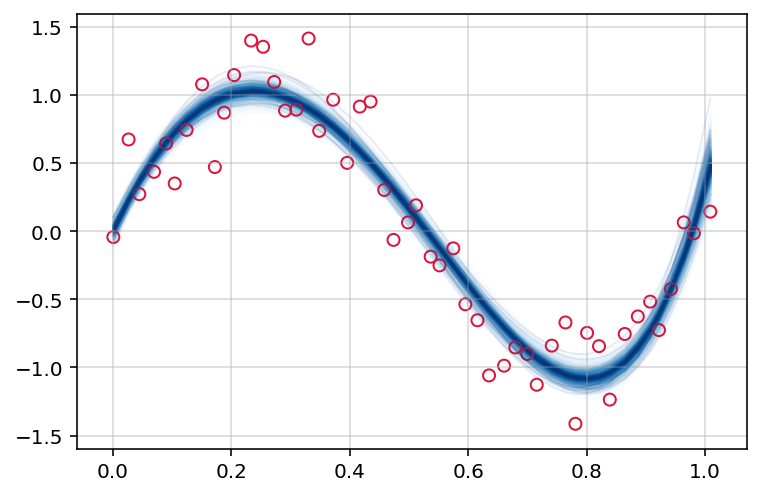

In [17]:
mvn = multivariate_normal(mean=m.ravel(), cov=Sigma)

fig, ax = plt.subplots(1, 1)
plot_gp_dist(ax, (Phi @ mvn.rvs(500).T).T, X, palette="Blues")
ax.scatter(X, y, facecolors="none", edgecolor="crimson")
ax.grid(alpha=0.5)

### Sequential Sparse Bayesian Learning Algorithm

$$
$$

In [76]:
from numpy.linalg import inv

In [186]:
poly = PolynomialFeatures(degree=20, include_bias=True)
Phi = poly.fit_transform(X[:, np.newaxis])
Phi = np.exp(-(X[np.newaxis, :] - X[:, np.newaxis]) ** 2 / 2)

In [187]:
N, M = Phi.shape

1. Initialize $\beta$

2. Initialize one basis function $\boldsymbol{\varphi}_1$, with hyperparameter $\alpha_1$ set using
$$
    \alpha_i = \frac{s_i^2}{q_i^2 - s_i}
$$

Where
* $s_i = \boldsymbol{\varphi}_i^T {\bf C}_{-i}^{-1}\boldsymbol{\varphi}_i$
* $q_i = \boldsymbol{\varphi}_i^T {\bf C}_{-i}^{-1}{\bf t}$,

With the remaining hyperparameters $\alpha_j$ for $i \neq j$ initialized to infinity so that only $\boldsymbol \varphi_i$ is included in the model.

In practice, it is conveniento to evaluate the quantitites

$$
    Q_i = \varphi_i^T {\bf C}^{-1} {\bf t}
$$

$$
    Si = \varphi_i^T {\bf C}^{-1} \varphi_i
$$

The quality and sparseness variables can then be expressed in the form
$$
    q_i = \frac{\alpha_i Q_i}{\alpha_i - Si}
$$

$$
    s_i = \frac{\alpha_i S_i}{\alpha_i - Si}
$$

In [188]:
def compute_C_inv(beta, Phi, A, N):
    C = 1 / beta *  np.identity(N) + Phi @ inv(A) @ Phi.T
    C_inv = inv(C)
    return C_inv

In [189]:
beta = np.abs(randn())
i = 0
# Initialize A with every parameter set to a large value
A = np.diag([10e9] * M)

In [190]:
for _ in range(100):
    # Evaluate Σ and m
    Sigma = np.linalg.inv(A + beta * Phi.T @ Phi)
    m = beta * Sigma @ Phi.T @ y[:, np.newaxis]
    C_inv = compute_C_inv(beta, Phi, A, N)
    # Evaluate qi and si for all basis functions
    S = np.einsum("ij,ik,kj->j", Phi, C_inv, Phi)
    Q = np.einsum("ij,ik,k->j", Phi, C_inv, y)

    alpha = np.diag(A)
    q = (alpha * Q) / (alpha - S)
    s =(alpha * S) / (alpha - S)
    new_alphas =  s ** 2 / (q ** 2 - s)
    
    # Select a candidate basis function
    i = np.random.randint(low=0, high=M)
    if q[i] ** 2 > s[i]:
        A[i,i] = new_alphas[i]
    # Remove the basis function from the 
    elif q[i] ** 2 <= s[i] and not np.isclose(1 / A[i,i], 0):
        A[i,i] = 10e9
    # Update β
    beta = ((N - np.trace(1 - Sigma * A)) /\
            np.linalg.norm(y[:, np.newaxis] - Phi @ m) ** 2)

In [191]:
Sigma = np.linalg.inv(A + beta * Phi.T @ Phi)
m = beta * Sigma @ Phi.T @ y[:, np.newaxis]

In [192]:
drop_i = np.where(A >= 10e9)[0]

array([ 0,  3,  4,  5,  6,  8,  9, 11, 12, 15, 16, 17, 19, 21, 22, 23, 24,
       25, 26, 27, 28, 30, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45,
       46, 47, 48, 49])

In [193]:
new_A = np.diag(np.delete(np.diag(A), drop_i))
new_Phi =np.delete(Phi, drop_i, axis=-1)
new_Sigma = np.linalg.inv(new_A + beta * new_Phi.T @ new_Phi)
new_m = beta * new_Sigma @ new_Phi.T @ y[:, np.newaxis]

In [197]:
# The support vectors
svs = np.array(list(set(np.arange(50)) - set(drop_i)))
svs

array([ 1,  2, 35,  7, 10, 43, 13, 14, 18, 20, 29, 31])

/miniconda3/lib/python3.7/site-packages/scipy/stats/_multivariate.py:660: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


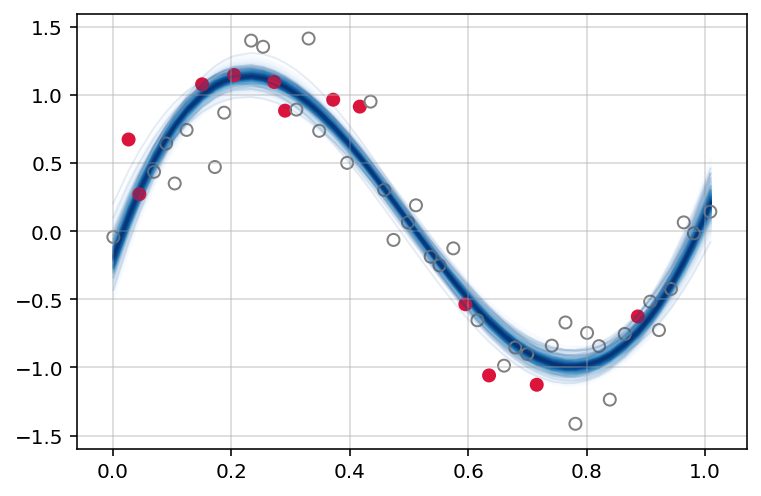

In [196]:
mvn = multivariate_normal(mean=new_m.ravel(), cov=new_Sigma)

colors = ["crimson" if c in svs else "gray" for c in range(50)]
edges = ["crimson" if c in svs else "none" for c in range(50)]

fig, ax = plt.subplots(1, 1)
plot_gp_dist(ax, (new_Phi @ mvn.rvs(500).T).T, X, palette="Blues")
ax.scatter(X, y, facecolors=edges, edgecolor=colors)
ax.grid(alpha=0.5)